<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch05/01_main-chapter-code/ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>


# 5장: 레이블이 없는 데이터를 활용한 사전 훈련

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        # "tensorflow" # OpenAI의 사전 훈련된 가중치를 위해서
       ]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.8
numpy 버전: 2.4.0
tiktoken 버전: 0.12.0
torch 버전: 2.8.0+cu126


- 이 장에서 LLM을 사전 훈련하기 위해 훈련 루프를 구현하고 기본적인 모델 평가 방법을 알아 보겠습니다.
- 이 장의 끝에서는 OpenAI의 사전 훈련된 가중치를 우리가 직접 구현한 모델에 로드해 보겠습니다.

<img src="images/llm_from_scratch/ch05_compressed/01.webp" width=800px>

- 이 장에서 다루는 주제는 다음과 같습니다.

<img src="images/llm_from_scratch/ch05_compressed/02.webp" width=800px>

## 5.1 텍스트 생성 모델 평가

- 이전 장에 코드를 사용하여 GPT 모델을 초기화하는 방법을 간략히 정리합니다.
- 그다음 LLM을 위한 기본적인 평가 지표를 소개합니다.
- 이 절의 마지막에서 이 평가 지표를 훈련 세트와 검증 세트에 적용합니다.

### 5.1.1 GPT를 사용해 텍스트 생성하기

- 이전 장의 코드를 사용하여 GPT 모델을 초기화합니다.

In [2]:
import torch
# 이전에 작성했던 GPTModel 클래스를 가져옵니다.
from previous_chapters import GPTModel

# 1. 모델 설정값 정의 (Hyperparameters)
# GPT-2 (Small 버전 - 124M 파라미터)의 구조를 본뜬 설정입니다.
# 딕셔너리 형태로 묶어서 관리하면 나중에 설정을 바꾸기 편합니다.
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 어휘 사전 크기 (OpenAI의 BPE 토크나이저 기준)
                           # 즉, 모델이 알 수 있는 단어(토큰)의 총개수입니다.

    "context_length": 256, # 문맥 길이 (Context Window)
                           # 원본 GPT-2는 1024지만, 여기서는 학습 속도와 메모리 절약을 위해
                           # 256으로 줄여서 테스트합니다. (한 번에 볼 수 있는 최대 단어 수)

    "emb_dim": 768,        # 임베딩 차원 (Embedding Dimension)
                           # 하나의 단어를 768개의 숫자로 표현하겠다는 뜻입니다.
                           # 이 숫자가 클수록 단어의 의미를 더 정밀하게 표현할 수 있습니다.

    "n_heads": 12,         # 멀티 헤드 어텐션의 헤드 개수
                           # 768차원을 12명이 나눠서(64차원씩) 병렬로 처리합니다.

    "n_layers": 12,        # 트랜스포머 블록(층)의 개수
                           # 이 블록을 12층으로 쌓아 올려서 '깊은(Deep)' 신경망을 만듭니다.

    "drop_rate": 0.1,      # 드롭아웃 비율 (Dropout Rate)
                           # 학습 시 10%의 뉴런을 랜덤하게 꺼서 과적합(Overfitting)을 막습니다.

    "qkv_bias": False      # 편향(Bias) 사용 여부
                           # 쿼리(Q), 키(K), 값(V)을 만드는 선형 계층에 편향값을 더할지 결정합니다.
                           # (최신 모델들은 종종 이를 False로 설정하여 파라미터를 줄입니다.)
}

# 2. 랜덤 시드 고정
# 모델의 가중치 초기화가 매번 똑같이 일어나도록 하여,
# 언제 실행하든 같은 결과가 나오게 합니다. (재현성 확보)
torch.manual_seed(123)

# 3. 모델 인스턴스 생성
# 위에서 정의한 설계도(GPT_CONFIG_124M)를 넣어 실제 모델을 만듭니다.
# 이제 'model' 변수 안에는 12층짜리 거대한 신경망이 들어있습니다.
model = GPTModel(GPT_CONFIG_124M)

# 4. 평가 모드로 전환 (매우 중요!)
# 모델을 학습(Training)이 아닌 사용(Inference/Evaluation) 모드로 바꿉니다.
# 이 함수를 실행해야 드롭아웃(drop_rate=0.1)이 비활성화되어,
# 모든 뉴런이 100% 능력을 발휘하며 일관된 결과를 냅니다.
model.eval();

- 위에서 드롭아웃을 0.1로 지정했지만 요즘에는 드롭아웃을 사용하지 않고 LLM을 훈련하는 경우가 많습니다.
- 최신 LLM은 (초기 GPT 모델과 달리) 쿼리, 키, 값 행렬을 위한 `nn.Linear` 층에서 편향 벡터를 사용하지 않습니다. 그래서 `"qkv_bias": False`로 지정합니다.
- 모델 훈련에 필요한 계산 자원을 절감하기 위해 문맥 길이(`context_length`)를 256 토큰으로 줄입니다. 원본 1억 2,400만 파라미터의 GPT-2 모델은 1024개의 토큰을 사용했습니다.
  - 대부분의 독자들은 이 코드 예제를 랩탑 컴퓨터에서 실행하기 때문입니다.
  - 하지만 `context_length`를 1,024개 토큰으로 늘려서 실험해도 괜찮습니다(어떤 코드도 바꿀 필요가 없습니다)
  - 나중에 `context_length`가 1,024인 모델을 사전 훈련된 가중치에서 로드하겠습니다.

- 그 다음이 이전 장에서 만든 `generate_text_simple` 함수를 사용해 텍스트를 생성합니다.
- 또한 두 개 유틸리티 함수 `text_to_token_ids`와 `token_ids_to_text`를 정의합니다. 이 장에서 토큰과 텍스트 표현 사이를 전환하는데 사용하겠습니다.

<img src="images/llm_from_scratch/ch05_compressed/03.webp" width=900px>

In [3]:
import tiktoken
import torch
from previous_chapters import generate_text_simple

# 1. 입력 변환 함수 (Encoding Helper)
# 사람의 언어(Text)를 모델이 이해하는 숫자 텐서(Tensor)로 변환합니다.
def text_to_token_ids(text, tokenizer):
    # tokenizer.encode: 텍스트를 정수 리스트로 변환합니다.
    # allowed_special: '<|endoftext|>' 같은 특수 토큰을 문자로 취급하지 않고 
    #                  기능을 가진 토큰으로 인식하도록 허용합니다.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    
    # 리스트를 파이토치 텐서로 변환합니다.
    encoded_tensor = torch.tensor(encoded)
    
    # unsqueeze(0): 배치 차원을 추가합니다.
    # 모델은 항상 [배치 크기, 시퀀스 길이] 형태의 입력을 기대합니다.
    # 예: [1, 2, 3] -> [[1, 2, 3]] (1개의 문장이라는 것을 명시)
    encoded_tensor = encoded_tensor.unsqueeze(0) 
    
    return encoded_tensor

# 2. 출력 변환 함수 (Decoding Helper)
# 모델이 내뱉은 숫자 텐서(Tensor)를 다시 사람의 언어(Text)로 변환합니다.
def token_ids_to_text(token_ids, tokenizer):
    # squeeze(0): 불필요한 배치 차원을 제거합니다.
    # 예: [[1, 2, 3]] -> [1, 2, 3]
    flat = token_ids.squeeze(0) 
    
    # tokenizer.decode: 정수 리스트(.tolist())를 받아서 문자열로 복원합니다.
    return tokenizer.decode(flat.tolist())

# --- 실행 코드 ---

# 3. 초기 설정
start_context = "Every effort moves you" # 모델에게 줄 첫 문장(프롬프트)
tokenizer = tiktoken.get_encoding("gpt2") # GPT-2용 토크나이저 로드

# 4. 텍스트 생성 실행
# 입력 텍스트를 텐서로 바꾸고 -> 모델에 넣어 생성하고 -> 결과 텐서를 받습니다.
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer), # "Every..."를 텐서로 변환
    max_new_tokens=10, # 10개의 단어를 추가로 생성
    context_size=GPT_CONFIG_124M["context_length"]
)

# 5. 결과 확인
# 생성된 숫자 텐서를 다시 텍스트로 바꿔서 출력합니다.
print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 위해서 볼 수 있듯이 모델이 아직 훈련되지 않았기 때문에 좋은 텍스트를 생성하지 못합니다.
- 훈련 과정에서 어떤 것이 좋은 텍스트인지 어떻게 정량적으로 측정할 수 있을까요?
- 다음 절에서 훈련 과정을 모니터링할 수 있도록 생성된 출력의 손실을 계산하는 지표를 소개합니다.
- LLM 미세 튜닝을 다루는 다음 장에서 모델의 품질을 측정하는 또 다른 방법을 소개하겠습니다.

### 5.1.2 텍스트 생성 손실 계산하기: 크로스 엔트로피와 혼잡도

- 두 개의 훈련 샘플(행)에 대한 토큰 ID를 담고 있는 `inputs` 텐서가 있다고 가정해보죠.
- `inputs`에 해당하는 `targets`은 모델이 생성 해야할 토큰 ID를 담고 있습니다.
- 2장에서 데이터 로더를 구현할 때 설명했듯이 `targets`은 `inputs`에서 한 토큰씩 앞으로 이동한 것입니다.

In [4]:
# 1. 데이터셋 준비 (Next Token Prediction)
# 입력(inputs): 모델이 현재 보고 있는 단어들입니다.
# 정답(targets): 각 입력 단어 바로 '다음에 와야 할' 단어들입니다. (오른쪽으로 한 칸 Shift 된 형태)
# 예: "Every effort moves" -> 다음 단어 예측 -> "effort moves you"
inputs = torch.tensor([[16833, 3626, 6100],   # ["every", "effort", "moves"]
                       [40,    1107, 588]])   # ["I",     "really", "like"]

targets = torch.tensor([[3626, 6100, 345],    # ["effort", "moves", "you"]
                        [1107, 588, 11311]])  # ["really", "like", "chocolate"]

- `inputs`을 모델에 주입하면 각각 세 개의 토큰으로 구성된 두 개의 입력 샘플에 대한 로짓 벡터를 얻습니다.
- 각각의 토큰는 어휘 사전 크기에 해당하는 50,257차원의 벡터입니다.
- 소프트맥스 함수를 적용하여 로짓 텐서을 확률 점수를 담고 있는 동일 차원의 텐서로 바꿀 수 있습니다.

In [5]:
# 2. 모델 추론 (Forward Pass)
# torch.no_grad(): 지금은 학습(가중치 업데이트)을 하는 게 아니라 결과만 볼 것이므로, 
# 미분값(Gradient) 계산을 꺼서 메모리를 아끼고 속도를 높입니다.
with torch.no_grad():
    # inputs(2x3)가 들어가면 -> logits(2x3x50257)이 나옵니다.
    logits = model(inputs)

# 3. 확률 변환
# logits은 -무한대 ~ +무한대의 점수이므로, softmax를 통해 0~1 사이의 확률값으로 바꿉니다.
# dim=-1: 마지막 차원(단어장 크기)에 대해 확률 합이 1이 되도록 계산합니다.
probas = torch.softmax(logits, dim=-1) 

print("확률 텐서 크기:", probas.shape) 
# 예상 출력: torch.Size([2, 3, 50257])
# 의미: (문장 2개, 각 문장의 단어 3개, 각 단어마다 50257개의 후보 단어 확률)

확률 텐서 크기: torch.Size([2, 3, 50257])


- 매우 작은 어휘 사전을 사용하는 아래 그림에서 확률 점수를 텍스트로 바꾸는 방법을 보여 줍니다. 이 장의 끝에서 이에 대해 논의하겠습니다.

<img src="images/llm_from_scratch/ch05_compressed/04.webp" width=900px>

- 이전 장에서 설명했듯이 `argmax` 함수를 적용하여 확률 점수를 토큰 ID 바꿀 수 있습니다.
- 앞의 소프트맥스 함수는 각 토큰에 대해서 50,257 차원의 벡터를 생성합니다. `argmax` 함수는 이 벡터에서 가장 높은 확률을 가진 위치를 반환합니다. 이것이 주어진 토큰에 대한 예측 토큰의 아이디입니다.

- 배치에는 각각 세 개 토큰으로 구성된 두 개의 입력 샘플이 있으므로 2x3 크기의 예측 토큰을 얻습니다.

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)

토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 이 토큰을 디코딩하면 모델이 예측해야 할 토큰, 즉 타겟 토큰과 매우 다른 것을 알 수 있습니다.

In [7]:
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

첫 번째 샘플의 타깃:  effort moves you
첫 번째 샘플의 타깃:  Armed heNetflix


- 이는 모델이 아직 훈련되지 않았기 때문입니다.
- 모델을 훈련하려면 정답 예측(타깃)에서 얼만큼 떨어져 있는지 알아야 합니다.

<img src="images/llm_from_scratch/ch05_compressed/06.webp" width=900px>

- 타겟 인덱스에 해당하는 토큰 확률은 다음과 같습니다.

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [2, 3, 50257]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 확률이 1에 가까워지도록 이 값들을 최대화하는 것이 목표입니다.
- 수학적 최적화에서는 확률 점수 자체를 최대화하는 것보다 확률 점수의 로그를 최대화하는 것이 쉽습니다.

In [9]:
# 토큰 확률의 로그를 계산합니다.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 그 다음 로그 확률의 평균을 계산합니다.

In [10]:
# 각 토큰에 대한 평균 확률을 계산합니다.
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 모델 가중치를 최적화하여 평균 로그 확률을 가능한 크게 만드는 것이 목표입니다.
- 로그 때문에 가장 큰 가능한 값은 0이며, 현재는 0에서 부터 멀리 떨어져 있습니다.

- 딥러닝 에서는 평균 로그 확률을 최대화하는 것 대신에 음의 평균 로그 확률을 최소화하는 것이 일반적입니다. 이 예제의 경우 -10.7722를 최대화하여 0에 가깝게 만드는 것 대신에 10.7722을 최소화하여 0에 가깝게 만듭니다.
- -10.7722의 음수 값, 즉 10.7722을 딥러닝에서는 크로스 엔트로피 손실이라고 부릅니다.

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- 파이토치는 이전 단계를 수행하는 `cross_entropy` 함수를 제공합니다.

<img src="images/llm_from_scratch/ch05_compressed/07.webp" width=600px>

- `cross_entropy` 함수를 적용하기 전에 로짓과 타깃의 크기를 확인해야 합니다.

In [12]:
# 로짓의 크기는 (batch_size, num_tokens, vocab_size)입니다.
print("로짓 크기:", logits.shape)

# 타깃의 크기는 (batch_size, num_tokens)입니다.
print("타깃 크기:", targets.shape)

로짓 크기: torch.Size([2, 3, 50257])
타깃 크기: torch.Size([2, 3])


- 파이토치의 `cross_entropy` 함수를 위해 배치 차원을 기준으로 합쳐서 텐서를 펼쳐야 합니다.

In [13]:
# 4. 손실 계산을 위한 평탄화 (Flattening)
# CrossEntropyLoss 함수는 [배치, 클래스] 형태의 2차원 입력을 선호합니다.
# 따라서 "2개의 문장에 있는 3개의 단어"를 -> "총 6개의 단어 문제"로 일렬로 폅니다.

# (2, 3, 50257) -> (6, 50257) : 배치와 시퀀스 길이를 합칩니다.
logits_flat = logits.flatten(0, 1)

# (2, 3) -> (6) : 정답지도 일렬로 쭉 폅니다.
targets_flat = targets.flatten()

print("펼친 로짓:", logits_flat.shape)   # torch.Size([6, 50257])
print("펼친 타깃:", targets_flat.shape)  # torch.Size([6])

펼친 로짓: torch.Size([6, 50257])
펼친 타깃: torch.Size([6])


- 타깃은 토큰 ID이며, 최대화해야 할 로짓 텐서의 인덱스를 나타냅니다.
- 파이토치의 `cross_entropy` 함수는 최대화할 토큰 인덱스에 대해 자동으로 소프트맥스와 로그 확률 계산을 수행합니다.

In [14]:
# 손실(Loss) 계산: Cross Entropy
# 모델의 예측값(logits_flat)과 실제 정답(targets_flat)을 비교하여 오차를 계산합니다.
# 주의: 이 함수는 내부적으로 Softmax를 자동으로 수행합니다. 
#       따라서 확률값(probas)이 아닌 생(Raw) 로짓(logits)을 넣어야 합니다.
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

print("손실값(Loss):", loss) 
# 출력 예시: tensor(10.82...) -> 숫자가 작을수록 정답에 가깝다는 뜻입니다.

손실값(Loss): tensor(10.7940)


- 크로스 엔트로피 손실에 관련된 개념은 LLM의 혼잡도입니다.
- 혼잡도는 크로스 엔트로피 손실에 지수 함수를 적용한 것입니다.

In [15]:
# 펄플렉서티(Perplexity, PPL) 계산
# 손실값(Loss)은 로그 스케일이라 직관적으로 와닿지 않습니다.
# 이를 지수함수(exp)에 통과시켜 사람이 이해하기 쉬운 수치로 변환합니다.
# 공식: PPL = e^(Loss)
perplexity = torch.exp(loss)

print("펄플렉서티(Perplexity):", perplexity)
# 의미: "모델이 다음 단어를 고를 때, 평균적으로 몇 개의 단어 중에서 고민(헷갈림)하는가?"

펄플렉서티(Perplexity): tensor(48725.8203)


- 혼잡도는 모델이 각 단계에서 불확실해하는 실제 어휘사전 크기를 나타내기 때문에 원시 손실 값보다 이해하기 더 쉽습니다(이 예에서는 48,725개 단어 또는 토큰).
- 다른 말로 하면, 혼잡도는 모델이 예측한 확률 분포가 데이터셋에 있는 단어의 실제 분포와 얼마나 잘 맞는지를 측정합니다.
- 손실과 비슷하게 낮은 혼잡도는 모델 예측이 실제 분포에 가깝다는 것을 나타냅니다.

### 5.1.3 훈련 세트와 검증 세트의 손실 계산하기

- LLM 훈련을 위해 비교적 작은 데이터셋을 사용합니다(사실 단편 소설 하나를 사용합니다).
- 이유는 다음과 같습니다.
  - 적절한 GPU가 없는 랩탑 컴퓨터에서 몇 분 안에 코드 예제가 실행되어야 합니다.
  - 교육 목적을 위해 훈련이 비교적 빨리 끝나야 합니다(몇 주가 아니라 몇 분 만에).
  - 사용 권리를 위반하지 않으며 깃허브 저장소에 저장할 수 있는 크기의 공개된 텍스트를 사용해야 합니다.
- 예를 들어, Llama 2 7B는 2조 개의 토큰에서 훈련하기 위해 A100 GPU에서 184,320 GPU 시간이 필요합니다.
  - 이 글을 쓰는 시점에, AWS의 8xA100 클라우드 서버의 시간당 가격은 약 \$30입니다.
  - 따라서 대략 계산하면 이 LLM을 훈련하는데 184,320 / 8 * \$30 =  \$690,000이 듭니다.
- 아래에서는 2장에서 다루었던 데이터셋을 사용합니다.

In [16]:
import os
import requests

file_path = "datas/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 다운로드한 텍스트를 확인하기 위해 처음과 끝에서 100 개의 문자를 출력하여 보죠.

In [17]:
# 처음 99개 문자
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
# 마지막 99개 문자
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("문자:", total_characters)
print("토큰:", total_tokens)

문자: 20479
토큰: 5145


이 텍스트의 토큰이 5,145개 뿐이라 LLM을 훈련하기에 너무 적어 보일 수 있습니다. 하지만 이는 교육적인 목적을 위해서입니다(나중에 사전 훈련된 가중치를 로드하겠습니다).

- 그 다음 데이터셋을 훈련 세트와 검증 세트로 나누고 2장의 데이터 로더를 사용해 LLM 훈련을 위한 배치를 준비합니다.
- 시각화때문에 아래 그림은 `max_length=6`라고 가정하지만, 훈련 데이터 로더에서 `max_length`는 LLM이 지원하는 문맥 길이와 같습니다.
- 아래 그림은 간단하게 나타내려고 입력 토큰만 보여줍니다.
  - LLM을 텍스트에 있는 다음 단어를 예측하도록 훈련하기 때문에 타깃은 한 토큰씩 이동한 것외에는 입력과 같습니다.

<img src="images/llm_from_scratch/ch05_compressed/09.webp" width=900px>

In [20]:
import torch
from previous_chapters import create_dataloader_v1

# 1. 데이터 분할 (Data Splitting)
# 전체 데이터를 9:1 비율로 나눕니다.
# - 90% (Train): 모델이 패턴을 배우는 데 사용
# - 10% (Validation): 모델이 잘 배우고 있는지 평가하는 데 사용 (본 적 없는 데이터)
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data)) # 분할 기준점 인덱스 계산

train_data = text_data[:split_idx] # 처음부터 90% 지점까지
val_data = text_data[split_idx:]   # 90% 지점부터 끝까지

# 

# 2. 랜덤 시드 고정
# 데이터 로더 내부에서 데이터를 섞는(Shuffle) 순서가 매번 같도록 고정합니다.
# 이는 실험 결과를 재현 가능하게 만드는 데 중요합니다.
torch.manual_seed(123)

# 3. 학습용 데이터 로더 생성 (Train Loader)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,         # 한 번에 2개의 샘플씩 묶어서 처리
    max_length=GPT_CONFIG_124M["context_length"], # 한 샘플당 토큰 길이 (예: 256)
    
    # stride(보폭): 윈도우가 이동하는 간격
    # stride와 max_length가 같으면 데이터가 겹치지 않고 딱딱 끊어서 가져옵니다.
    # (반면, stride가 작으면 데이터가 겹치게 되어 학습 데이터 양이 늘어나는 효과가 있습니다)
    stride=GPT_CONFIG_124M["context_length"],
    
    # drop_last=True: 
    # 데이터 개수가 배치 사이즈로 딱 나누어떨어지지 않을 때, 
    # 마지막에 남는 짜투리 데이터를 버립니다. (학습 안정성을 위해 주로 사용)
    drop_last=True,
    
    # shuffle=True:
    # 데이터를 무작위로 섞어서 모델이 순서 자체를 외우는 것을 방지합니다. (학습 시 필수!)
    shuffle=True,
    num_workers=0 # 데이터 로딩에 사용할 프로세스 수 (0은 메인 프로세스만 사용)
)

# 4. 검증용 데이터 로더 생성 (Validation Loader)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    
    # drop_last=False:
    # 검증할 때는 모든 데이터를 빠짐없이 평가해야 하므로 남는 데이터도 버리지 않습니다.
    drop_last=False,
    
    # shuffle=False:
    # 검증 결과의 일관성을 위해 섞지 않고 순서대로 평가합니다.
    shuffle=False,
    num_workers=0
)

In [21]:
# 유효성 검사
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
          "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
          "`training_ratio`를 증가시키세요.")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
          "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
          "`training_ratio`를 증가시키세요.")

- 컴퓨팅 자원을 절감하고 데이터셋이 매우 작기 때문에 비교적 작은 배치 크기를 사용합니다.
- 예를 들어 Llama 2 7B는 배치 크기 1024에서 훈련되었습니다.

- 데이터가 올바르게 로드되었는지 확인합니다.

In [22]:
print("훈련 데이터 로더:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n검증 데이터 로더:")
for x, y in val_loader:
    print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


- 토큰 크기가 예상 범위 안에 있는지 추가로 확인합니다.

In [23]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("훈련 토큰 수:", train_tokens)
print("검증 토큰 수:", val_tokens)
print("모든 토큰 수:", train_tokens + val_tokens)

훈련 토큰 수: 4608
검증 토큰 수: 512
모든 토큰 수: 5120


- 주어진 배치에서 크로스 엔트로피 손실을 계산 하는 유틸리티 함수를 작성 합니다
- 또한 데이터 로더에서 사용자가 지정한 배치 개수 만큼 추출하여 손실을 계산하는 두 번째 유틸리티 함수를 구현합니다.

In [24]:
import torch

# 함수 1: 단일 배치에 대한 손실 계산
def calc_loss_batch(input_batch, target_batch, model, device):
    # 1. 장치 이동 (CPU -> GPU)
    # 데이터를 모델이 있는 장치(device)로 옮깁니다. (예: cuda:0)
    # 모델과 데이터가 서로 다른 장치에 있으면 에러가 발생합니다.
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # 2. 모델 예측 (Forward Pass)
    # 입력을 넣어 예측값(Logits)을 얻습니다.
    logits = model(input_batch)

    # 3. 손실(Loss) 계산
    # CrossEntropyLoss는 (N, Class) 형태의 2차원 입력을 기대합니다.
    # 따라서 (Batch, Sequence, Vocab) 형태인 logits를 -> (Batch*Sequence, Vocab)으로 폅니다.
    # target_batch도 (Batch, Sequence) -> (Batch*Sequence)로 일렬로 폅니다.
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    
    return loss


# 함수 2: 데이터 로더(여러 배치)에 대한 평균 손실 계산
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    
    # 예외 처리: 데이터 로더가 비어있으면 NaN(Not a Number)을 반환
    if len(data_loader) == 0:
        return float("nan")
    
    # 1. 평가할 배치 개수 설정
    # num_batches가 지정되지 않았다면(None), 데이터 로더의 전체 데이터를 다 사용합니다.
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 사용자가 요청한 개수(num_batches)가 실제 데이터 개수보다 많으면
        # 실제 데이터 개수(len(data_loader))까지만 확인하도록 제한합니다.
        num_batches = min(num_batches, len(data_loader))
    
    # 2. 배치 반복문 실행
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # 지정된 배치 개수만큼만 루프를 돕니다.
        if i < num_batches:
            # 위에서 만든 함수를 재사용해 현재 배치의 손실을 구합니다.
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            # 3. 손실 누적 (.item()의 중요성)
            # loss는 텐서(Tensor)입니다. 이를 그대로 더하면 계산 그래프가 계속 메모리에 남습니다.
            # .item()을 써서 순수 파이썬 실수형(float) 값만 뽑아내야 메모리 누수를 막을 수 있습니다.
            total_loss += loss.item()
        else:
            # 정해진 횟수를 채웠으면 루프를 중단합니다.
            break
            
    # 4. 평균 손실 반환
    return total_loss / num_batches

- CUDA를 지원하는 GPU를 가지고 있다면 어떤 코드도 변경할 필요 없이 GPU 에서 LLM을 훈련할 수 있습니다.
- `device` 설정을 통해 데이터를 LLM 모델과 동일한 장치에 로드합니다.

In [25]:
import torch

# 1. 장치(Device) 자동 설정
# 우선순위: CUDA(NVIDIA GPU) -> MPS(Apple Silicon Mac) -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU가 있으면 최우선으로 사용
    
elif torch.backends.mps.is_available():
    # Apple Silicon(M1/M2/M3 등)의 MPS 가속 기능 확인
    # 파이토치 버전 정보를 숫자(Major, Minor)로 분리합니다.
    major, minor = map(int, torch.__version__.split(".")[:2])

else:
    # 아무런 가속기도 없으면 일반 CPU를 사용합니다.
    device = torch.device("cpu")

print(f"Using {device} device.") # 현재 선택된 장치 출력


# 2. 모델을 장치로 이동
# 중요: nn.Module(모델)은 .to()를 쓰면 제자리(In-place)에서 이동됩니다.
# (텐서와 달리 'model = model.to(device)'라고 다시 할당할 필요가 없습니다.)
model.to(device) 

# 3. 랜덤 시드 고정
# 데이터 로더가 데이터를 섞을 때(shuffle), 그리고 모델 초기화 등에서 
# 매번 같은 결과가 나오도록 시드를 고정합니다.
torch.manual_seed(123) 

# 4. 초기 손실값(Baseline Loss) 확인
# 학습을 전혀 하지 않은 상태에서 손실값이 얼마나 나오는지 확인합니다.
# 이 값은 일종의 '기준점'이 되며, 학습 후 이보다 낮아져야 정상입니다.
with torch.no_grad(): # 평가만 할 것이므로 미분(Gradient) 계산을 끕니다 (메모리 절약).
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

Using cuda device.
훈련 손실: 10.987583266364204
검증 손실: 10.98110580444336


<img src="images/llm_from_scratch/ch05_compressed/10.webp" width=800px>

## 5.2 LLM 훈련하기

- 이 절에서는 LLM 훈련을 위한 코드를 구현합니다.
- 여기서는 간단한 훈련 함수를 만듭니다(이 훈련 함수를 학습률 워밍업, 코사인 어닐링, 그레이디언트 클리핑 같은 고급 기법으로 확장하고 싶다면 [부록 D](../../appendix-D/01_main-chapter-code)를 참고하세요).

<img src="images/llm_from_scratch/ch05_compressed/11.webp" width=600px>

In [26]:
import torch

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    모델을 학습시키는 메인 함수입니다.
    
    Args:
        model: 학습할 신경망 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더 (과적합 확인용)
        optimizer: 가중치 업데이트를 위한 최적화 도구 (예: AdamW)
        device: 학습을 수행할 장치 (CPU 또는 GPU)
        num_epochs: 전체 데이터를 몇 번 반복 학습할지 설정
        eval_freq: 몇 번의 스텝마다 평가를 진행할지 설정
        eval_iter: 평가 시 사용할 배치의 개수
        start_context: 샘플 생성 시 시작할 텍스트 문구
        tokenizer: 텍스트와 토큰 ID 간의 변환 도구
    """
    
    # 1. 기록용 리스트 초기화
    # 훈련 손실, 검증 손실, 처리한 총 토큰 수를 저장하여 나중에 그래프로 그릴 때 사용합니다.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 2. 메인 훈련 루프 시작 (Epoch 단위)
    for epoch in range(num_epochs):
        model.train()  # 모델을 '훈련 모드'로 전환 (드롭아웃, 배치정규화 등이 활성화됨)

        # 데이터 로더에서 배치 단위로 데이터를 가져옴
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # [중요] 이전 배치의 기울기(Gradient) 정보 초기화 (누적 방지)
            
            # 순전파 (Forward Pass) 및 손실 계산
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            # 역전파 (Backward Pass): 손실에 따른 각 가중치의 기울기 계산
            loss.backward() 
            
            # 가중치 업데이트: 계산된 기울기를 바탕으로 모델 파라미터 수정
            optimizer.step() 
            
            # 진행 상황 추적
            tokens_seen += input_batch.numel() # 처리한 토큰 수 누적
            global_step += 1

            # 3. 주기적인 평가 (Evaluation Step)
            # 지정된 스텝(eval_freq)마다 훈련/검증 손실을 계산해 모델 상태를 체크합니다.
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                
                # 기록 저장
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                # 진행 상황 출력 (로그)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 4. 에포크 종료 후 샘플 생성
        # 모델이 학습되면서 문장 생성 능력이 어떻게 변하는지 눈으로 확인합니다.
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    현재 모델의 성능(손실)을 측정하는 함수입니다. 학습에는 영향을 주지 않습니다.
    """
    model.eval() # 모델을 '평가 모드'로 전환 (드롭아웃 비활성화 등)
    
    with torch.no_grad(): # [중요] 기울기 계산 비활성화 (메모리 절약 및 속도 향상)
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train() # 평가가 끝나면 다시 '훈련 모드'로 복구해야 함
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    모델이 현재 어떻게 텍스트를 생성하는지 확인하기 위한 함수입니다.
    """
    model.eval() # 평가 모드 설정
    
    context_size = model.pos_emb.weight.shape[0] # 모델이 처리 가능한 최대 문맥 길이
    
    # 시작 텍스트를 토큰 ID로 변환(Encoding) 후 장치로 이동
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    with torch.no_grad(): # 생성 과정에서는 학습이 필요 없으므로 기울기 계산 끔
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        
    # 생성된 토큰 ID들을 다시 텍스트로 변환(Decoding)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    # 보기 좋게 줄바꿈 문자를 공백으로 치환하여 출력
    print(decoded_text.replace("\n", " ")) 
    
    model.train() # 다시 훈련 모드로 복구

- 위에 정의한 훈련 함수로 LLM을 훈련해 보죠.

In [27]:
import torch

# 노트:
# 실행 시간을 계산하고 싶다면 다음 주석을 해제하세요. (학습에 얼마나 걸리는지 측정용)
# import time
# start_time = time.time()

# 1. 재현성(Reproducibility) 설정
# 매번 실행할 때마다 결과가 달라지지 않도록 랜덤 시드를 고정합니다.
# 이렇게 하면 가중치 초기화 등이 동일하게 시작되어 실험 결과를 비교하기 좋습니다.
torch.manual_seed(123)

# 2. 모델 인스턴스 생성
# 사전에 정의된 설정(GPT_CONFIG_124M)을 사용하여 GPT 모델 구조를 만듭니다.
model = GPTModel(GPT_CONFIG_124M)

# 3. 모델을 장치로 이동
# 모델의 파라미터들을 GPU(cuda) 또는 CPU로 옮깁니다. (이전에 정의한 device 변수 사용)
model.to(device)

# 4. 옵티마이저(Optimizer) 설정
# AdamW: Adam 알고리즘에 가중치 감쇠(Weight Decay)가 개선된 버전으로, LLM 학습에 표준적으로 쓰입니다.
# lr=0.0004: 학습률(Learning Rate). 한 번의 업데이트로 가중치를 얼마나 변경할지 결정합니다.
# weight_decay=0.1: 과적합(Overfitting)을 막기 위해 가중치가 너무 커지지 않도록 억제하는 규제 값입니다.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# 5. 학습 루프 실행
num_epochs = 10  # 전체 데이터를 10번 반복해서 학습

# train_model_simple 함수를 호출하여 학습을 진행하고, 결과(손실 기록 등)를 반환받습니다.
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,       # 5번의 스텝(배치 업데이트)마다 검증(Validation)을 수행
    eval_iter=5,       # 검증 시 5개의 배치만 사용하여 빠르게 손실 계산
    start_context="Every effort moves you", # 에포크마다 생성 테스트를 해볼 시작 문구
    tokenizer=tokenizer
)

# Note:
# 실행 시간을 계산하고 싶다면 다음 주석을 해제하세요.
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"훈련 소요 시간: {execution_time_minutes:.2f}분.")

에포크 1 (Step 000000): 훈련 손실 9.820, 검증 손실 9.932
에포크 1 (Step 000005): 훈련 손실 8.065, 검증 손실 8.341
Every effort moves you,,,,,,,,,,,,.                                     
에포크 2 (Step 000010): 훈련 손실 6.621, 검증 손실 7.052
에포크 2 (Step 000015): 훈련 손실 6.047, 검증 손실 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
에포크 3 (Step 000020): 훈련 손실 5.582, 검증 손실 6.480
에포크 3 (Step 000025): 훈련 손실 5.524, 검증 손실 6.402
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
에포크 4 (Step 000030): 훈련 손실 5.110, 검증 손실 6.354
에포크 4 (Step 000035): 훈련 손실 4.987, 검증 손실 6.386
Every effort moves you, and a, and a, and a-- the picture. Gisburn, and a was, and a. I had been. of the of the of the of the of the of the of the of the of the. I had a
에포크 5 (Step 000040): 훈련 손실 4.369, 검증 손실 6.264
Every effort moves you, one of the picture--as of the picture--as of the of the of the picture--as of the fact of

- 여러분의 결과와 손실 값이 조금 다를 수 있습니다. 대체적으로 비슷하다면 (훈련 손실은 1이하이고 검증 손실은 7이하이면) 걱정할 필요가 없습니다.
- GPU 하드웨어와 CUDA 버전 또는 파이토치의 신버전에서 바뀐 변화 때문에 차이가 발생할 수 있습니다.
- CPU에서 이 예제를 실행하더라도 작은 차이를 볼 수 있습니다. 이런 차이를 만드는 원인 중 하나는 파이토치가 컴파일된 운영체제에 따라 `nn.Dropout`의 동작 방식이 다르기 때문입니다. 자세한 내용은 파이토치 [깃허브 이슈](https://github.com/pytorch/pytorch/issues/121595)를 참고하세요.

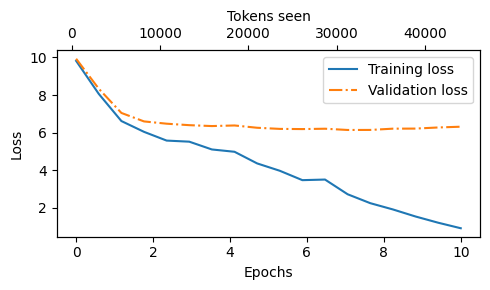

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에포크에 대한 훈련 손실과 검증 손실의 그래프를 그립니다.
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # 처리한 토큰 수에 대한 두 번째 x 축을 만듭니다.
    ax2 = ax1.twiny()  # y 축을 공유하는 두 번째 x 축을 만듭니다.
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 눈금을 정렬하기 위해 투명한 그래프를 만듭니다.
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("outputs/loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 위 결과를 보면 모델이 처음에는 이해할 수 없는 단어를 생성하지만 마지막으로 갈수록 문법적으로 어느 정도 정확한 문장을 생성합니다.
- 하지만 훈련 세트 손실과 검증 세트 손실을 보면 모델이 과대적합되기 시작합니다.
- 마지막 부분의 몇 문장을 확인하면 훈련 세트에 있는 내용이라는 것을 알 수 있습니다. 모델이 단순히 훈련 데이터를 암기한 것입니다.
- 매우 작은 훈련 세트를 사용하고 모델을 여러 에포크에서 훈련하고 있기 때문에 과대적합이 일어납니다.
  - 여기서는 교육적인 목적을 위해 LLM을 훈련합니다. 모델이 일관된 텍스트를 생성하는 방법을 학습할 수 있는지 확인하는 것이 주요 목적입니다.
  - 대량의 고가 하드웨어에서 몇 주 또는 몇 달 동안 이런 모델을 훈련하는 대신에 나중에 사전 훈련된 가중치를 로드하여 사용하겠습니다.

<img src="images/llm_from_scratch/ch05_compressed/13.webp" width=800px>

- 더 큰 훈련 데이터셋에서 오래 모델을 훈련하고 싶다면 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)을 참고하세요

## 5.3 무작위성을 제어하기 위한 디코딩 전략

- 위에서 구현한 GPT 모델처럼 작은 LLM의 추론 비용은 비교적 저렴합니다. 따라서 훈련에 GPU를 사용했더라도 추론에서는 GPU를 사용할 필요가 없습니다.
- 이전 장에서 만든 `generate_text_simple` 함수를 사용해 한 번에 하나의 단어(또는 토큰)씩 새로운 텍스트를 생성할 수 있습니다.
- 5.1.2절에서 설명했듯이 생성된 다음 토큰은 어휘사전의 모든 토큰 중에서 확률 점수가 가장 높은 토큰입니다.

In [29]:
# NEW: 이후 코드의 결과를 책과 일치하도록 만들기 위해 CPU를 사용합니다.
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- `generate_text_simple` 함수를 여러번 실행하더라도 LLM은 항상 동일한 출력을 생성합니다.
- `generate_text_simple`를 수정하기 위해 두 가지 디코딩 전략을 소개합니다. *온도 스케일링*과 *탑-k* 샘플링입니다.
- 이를 사용해 모델이 생성된 텍스트의 무작위성과 다양성을 조절할 수 있습니다.

### 5.3.1 온도 스케일링

- 이전에는 `torch.argmax`를 사용해 항상 가장 높은 확률을 가진 토큰을 다음 토큰으로 샘플링했습니다.
- 다양성을 추가하기 위해 확률 분포에서 샘플링하도록 `torch.multinomial(probs, num_samples=1)`을 사용해 토큰을 샘플링할 수 있습니다.
- 여기서 각 인덱스 선택 가능성은 입력 텐서에 있는 확률에 따라 결정됩니다.

- 여기에서 다음 토큰 생성에 대해 간략히 정리해 보겠습니다. 설명을 위해 매우 작은 어휘사전을 사용합니다.

In [30]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# 입력이 "every effort moves you"이고
# LLM이 다음 토큰을 위해 아래와 같은 로짓을 반환했다고 가정해 보죠.
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 생성될 토큰은 다음과 같습니다.
print(inverse_vocab[next_token_id])

forward


In [31]:
import torch

# 1. 재현성(Reproducibility) 설정
# 난수 생성기의 시드(Seed)를 123으로 고정합니다.
# 이렇게 하면 코드를 여러 번 실행해도 '무작위 뽑기'의 결과가 항상 똑같이 나옵니다.
# (실험 결과를 일정하게 유지하고 싶을 때 필수적입니다.)
torch.manual_seed(123)

# 2. 확률 분포에 기반한 랜덤 샘플링 (핵심!)
# probas: 모델이 예측한 다음 토큰들의 등장 확률 (예: "사과"=10%, "바나나"=80%, "포도"=10%)
# torch.multinomial: 위 확률(가중치)을 반영하여 주사위를 굴립니다.
#                    확률이 높을수록 뽑힐 가능성이 크지만, 낮은 확률의 토큰도 뽑힐 수 있습니다.
# num_samples=1: 딱 1개만 뽑습니다.
# .item(): 뽑힌 결과는 텐서(Tensor) 형태이므로, 이를 파이썬 정수(int) 값으로 변환합니다.
next_token_id = torch.multinomial(probas, num_samples=1).item()

# 3. 결과 출력
# inverse_vocab: {숫자 ID: "단어"} 형태로 된 사전(Dictionary)입니다.
# 위에서 뽑은 숫자(ID)를 사람이 읽을 수 있는 실제 단어로 바꾸어 출력합니다.
print(inverse_vocab[next_token_id])

forward


- `torch.argmax`로 가장 가능성이 높은 토큰을 결정하는 대신에 `torch.multinomial(probas, num_samples=1)`를 사용해 소프트맥스 분포에서 샘플링하여 가장 가능성이 높은 토큰을 결정할 수 있습니다.
- 설명을 위해 원래 소프트맥스 분포에서 1,000번 토큰을 샘플링해 보죠.

In [32]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # 재현가능성을 위한 랜덤 시드
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 온도 스케일링으로 분포와 선택 과정을 조절할 수 있습니다.
- "온도 스케일링"은 로짓을 0보다 큰 숫자로 나누는 것을 의미합니다.
- 1보다 큰 온도는 소프트맥스 함수를 적용한 후에 더 균등한 토큰 확률 분포를 만듭니다.
- 1보다 작은 온도는 소프트맥스 함수를 적용한 후에 더 결정론적인 분포(더 날카롭거나 뾰족한 분포)를 만듭니다.

In [33]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 온도 값
temperatures = [1, 0.1, 5]  # 원본, 낮은 온도, 높은 온도

# 스케일을 조정한 확률 계산
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

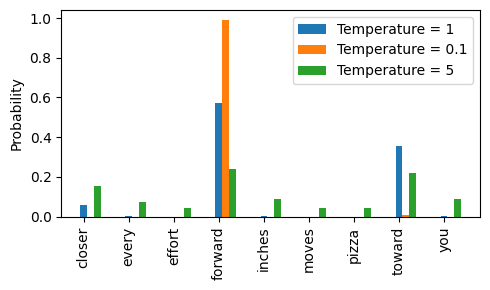

In [34]:
# 그래프 그리기
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("outputs/temperature-plot.pdf")
plt.show()

- 온도 0.1로 스케일을 조정하면 더 뾰족한 분포를 만들어, `torch.argmax`에 가까워져 항상 가장 가능성있는 토큰이 선택됩니다.

In [35]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 온도 5로 스케일을 조정한 확률은 더 균등한 분포가 됩니다.

In [36]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- LLM 입력이 "every effort moves you"일 경우 위와 같은 방법을 사용하면 "every effort moves you pizza"와 같이 3.2%의 확률(1,000번 중에 32번)로 이따금 말이 안되는 텍스트를 생성합니다.

### 5.3.2 탑-k 샘플링

- 높은 온도를 사용하여 출력의 다양성을 증가시키면서 말이 안되는 문장이 생성될 가능성을 낮추기 위해 가장 가능성있는 상위 k개 토큰으로 샘플링될 토큰을 제한할 수 있습니다.

<img src="images/llm_from_scratch/ch05_compressed/15.webp" width=700px>

- (이 그림의 숫자는 간단하게 나타내려고 소숫점 두자리 이후를 자른 값입니다. 소프트맥스 열의 값은 모두 더해서 1.0이 되어야 합니다)

- 코드로는 다음과 같이 구현할 수 있습니다.

In [38]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("탑-k 로짓:", top_logits)
print("탑-k 위치:", top_pos)

탑-k 로짓: tensor([6.7500, 6.2800, 4.5100])
탑-k 위치: tensor([3, 7, 0])


In [39]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
#위의 코드를 좀 더 효율적으로 구현
#자세한 내용은 다음을 참고하세요: https://github.com/rasbt/LLMs-from-scratch/discussions/326
new_logits = torch.full_like( # -inf 값을 담은 텐서를 만듭니다.
    next_token_logits, -torch.inf
)   
new_logits[top_pos] = next_token_logits[top_pos] # -inf 텐서에 상위 k개 값을 복사합니다.
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [45]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 텍스트 생성 함수 수정하기

- 이전 두 개의 절에서 온도 스케일링과 탑-k 샘플링을 소개했습니다.
- 두 개념을 사용해 앞서 LLM으로 텍스트를 생성할 때 사용한 `generate_sample` 함수를 수정해 새로운 `generate` 함수를 만들어 보죠.

In [ ]:
import torch

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    텍스트를 생성하는 함수입니다.
    
    Args:
        model: 학습된 LLM 모델
        idx: 현재까지의 문맥(토큰 인덱스들의 텐서) (Batch, Time)
        max_new_tokens: 최대로 생성할 토큰 수
        context_size: 모델이 한 번에 처리할 수 있는 최대 문맥 길이
        temperature: 생성 다양성 조절 (0.0 = 결정적/안전함, 높을수록 창의적/무작위)
        top_k: 확률이 높은 상위 k개 토큰만 후보로 남김 (이상한 단어 생성 방지)
        eos_id: '문장 끝'을 알리는 토큰 ID (이게 나오면 생성을 멈춤)
    """

    # 지정된 횟수(max_new_tokens)만큼 반복하며 한 글자씩 생성합니다.
    for _ in range(max_new_tokens):
        
        # 1. 문맥 자르기 (Context Cropping)
        # 입력 길이가 모델의 허용 범위(context_size)를 넘지 않도록, 가장 최근 토큰들만 남깁니다.
        idx_cond = idx[:, -context_size:]
        
        # 2. 모델 예측 (Forward Pass)
        # 기울기 계산을 꺼서 메모리를 아끼고 속도를 높입니다.
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 3. 마지막 토큰의 예측값 추출
        # 우리는 '다음 단어'만 궁금하므로, 시퀀스의 가장 마지막 타임 스텝의 로짓(Logits)만 가져옵니다.
        logits = logits[:, -1, :]

        # 4. Top-k 샘플링 (필터링 단계)
        # 확률이 너무 낮은 엉뚱한 단어들이 선택되는 것을 원천 차단합니다.
        if top_k is not None:
            # 상위 k개의 값(top_logits)만 구합니다.
            top_logits, _ = torch.topk(logits, top_k)
            # 상위 k개 중 가장 작은 값을 기준으로 삼습니다.
            min_val = top_logits[:, -1]
            # 기준보다 작은 값(순위 밖의 단어들)은 -infinity로 바꿉니다.
            # (나중에 softmax를 통과하면 확률이 0이 되어 절대 뽑히지 않게 됩니다.)
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 5. 온도 스케일링 (Temperature Scaling) 적용 여부 확인
        # temperature > 0: 확률에 기반해 '뽑기'를 합니다. (다양한 문장)
        # temperature == 0: 가장 확률 높은 것만 무조건 고릅니다. (일관된 문장)
        if temperature > 0.0:
            # [핵심] 로짓을 온도로 나눕니다.
            # 온도가 높으면(>1) 분포가 평평해져서 다양한 단어가 나올 확률이 오릅니다.
            # 온도가 낮으면(<1) 분포가 뾰족해져서 확실한 단어만 나올 확률이 오릅니다.
            logits = logits / temperature

            # (수치 안정성 팁): 로짓 값이 너무 크면 지수함수(exp) 계산 시 오버플로우가 날 수 있습니다.
            # 최댓값을 빼주면 결과 확률은 같으면서 값의 크기는 줄어들어 안전합니다.
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # 로짓을 확률(0~1 사이 값)로 변환합니다.
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 확률 분포에 따라 랜덤하게 하나를 뽑습니다. (Weighted Random Sampling)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 6. 그리디 샘플링 (Greedy Sampling)
        # 온도 설정이 없으면(0.0), 무조건 가장 높은 점수를 받은 토큰을 선택합니다.
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # 7. 조기 종료 (Early Stopping)
        # 만약 뽑힌 토큰이 '문장 종료(EoS)' 토큰이라면 더 이상 생성하지 않고 루프를 깹니다.
        if idx_next == eos_id:
            break

        # 8. 결과 누적
        # 방금 생성한 토큰(idx_next)을 기존 문장(idx) 뒤에 이어 붙입니다.
        # 이 새로운 문장이 다음 루프의 입력이 됩니다.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you stand," was down surprise, one of his glory, my lies by by


## 5.4 파이토치로 모델 로드하고 저장하기

- LLM 훈련에는 계산 비용이 많이 듭니다. 따라서 LLM 가중치를 저장하고 로드하는 것이 중요합니다.

<img src="images/llm_from_scratch/ch05_compressed/16.webp" width=800px>

- 파이토치에서는 `torch.save` 함수를 `.state_dict()` 메서드 결과에 적용해 소위 `state_dict`인 모델 가중치를 저장하는 것이 권장됩니다.

In [43]:
torch.save(model.state_dict(), "outputs/model.pth")

- 그다음 모델 가중치를 새로운 `GPTModel` 클래스 인스턴스에 로드할 수 있습니다.

In [ ]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.load_state_dict(torch.load("outputs/model.pth", map_location=device, weights_only=True))
model.eval()

- 일반적인 SGD 대신 Adam이나 AdamW와 같이 적응형 옵티마이저로 LLM을 훈련하는 것이 일반적입니다.
- 이런 적응형 옵티마이저는 모델 가중치마다 추가적인 파라미터를 저장합니다. 나중에 사전 훈련을 계속하려면 이 파라미터도 저장하는 것이 맞습니다.

In [45]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "outputs/model_and_optimizer.pth"
)

In [ ]:
import torch

# 1. 체크포인트 파일 로드
# 저장된 파일(.pth)을 읽어와서 파이썬 딕셔너리 형태로 만듭니다.
# weights_only=True: 보안을 위해 피클(pickle) 데이터 중 가중치 데이터만 로드하도록 제한합니다. (안전한 로딩)
checkpoint = torch.load("outputs/model_and_optimizer.pth", weights_only=True)

# 2. 모델 구조(Skeleton) 재생성
# 가중치를 담으려면, 가중치가 들어갈 '그릇(모델 구조)'이 먼저 메모리에 있어야 합니다.
# [중요] 저장할 때 사용했던 설정(GPT_CONFIG_124M)과 똑같이 만들어야 에러가 안 납니다.
model = GPTModel(GPT_CONFIG_124M)

# 3. 모델 가중치(Weight) 복원
# 체크포인트 딕셔너리에서 'model_state_dict' 키에 저장된 가중치들을 꺼내
# 방금 만든 빈 모델(model)에 덮어씌웁니다.
model.load_state_dict(checkpoint["model_state_dict"])

# 4. 옵티마이저 초기화
# 옵티마이저도 새로 생성해야 합니다. 이때 모델의 파라미터(model.parameters())를 연결해줍니다.
# 주의: 여기서 설정한 lr(학습률) 등은 초기 설정값이며, 바로 아래 줄에서 덮어씌워질 수 있습니다.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)

# 5. 옵티마이저 상태(State) 복원 (학습 재개 시 필수!)
# 옵티마이저는 단순히 학습률만 가지고 있는 게 아니라,
# 이전 학습 과정에서의 '관성(Momentum)'이나 '스텝 수' 같은 내부 정보를 가지고 있습니다.
# 이 정보를 복원해야 학습이 끊기지 않고 자연스럽게 이어집니다.
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# 6. 학습 모드 설정
# 불러온 직후에는 모델이 어떤 상태인지 모르므로, 다시 학습을 시작할 준비(train mode)를 합니다.
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

## 5.5 오픈AI에서 사전 훈련된 가중치 로드하기

- 앞서 하나의 단편 소설로 구성된 작은 데이터셋을 사용해 소규모 GPT-2 모델을 훈련했습니다.
- 구텐베르크 프로젝트에 있는 전체 책으로 더 오래 모델을 훈련하고 싶다면 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)을 참고하세요.
- 다행히 오픈AI는 GPT-2 모델의 가중치를 공개적으로 제공하기 때문에 대규모 말뭉치에서 모델을 재훈련하기 위해 수만에서 수십만 달러를 쓸 필요가 없습니다.

In [ ]:
import os
import requests
import torch

def load_gpt2_model(file_name, config):
    """
    GPT-2 사전 학습된 가중치(Pre-trained Weights)를 다운로드하고,
    초기화된 모델에 해당 가중치를 입혀서 반환하는 함수입니다.
    """
    # 1. 저장 경로 설정
    base_dir = "models/gpt2"
    os.makedirs(base_dir, exist_ok=True)  # 폴더가 없으면 새로 만듭니다.
    model_path = os.path.join(base_dir, file_name)
    
    # 다운로드 받을 원본 URL (HuggingFace 저장소)
    url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

    # 2. 파일 다운로드 (이미 파일이 있다면 건너뜀)
    if not os.path.exists(model_path):
        print(f"'{file_name}' 다운로드 중...")
        # 대용량 파일이므로 stream=True로 설정하여 조금씩 메모리에 올립니다.
        with requests.get(url, stream=True) as r:
            r.raise_for_status() # 404 등 에러 발생 시 예외 처리
            with open(model_path, 'wb') as f:
                # 8KB씩 조각(chunk)내어 파일에 씁니다.
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"다운로드 완료: {model_path}")
    else:
        print(f"이미 파일이 존재합니다: {model_path}")

    # 3. 모델 구조 생성 및 가중치 로드
    model = GPTModel(config) # 껍데기(Architecture) 생성
    
    # 저장된 가중치 파일을 불러옵니다.
    # map_location: 저장된 모델이 GPU용이라도, 현재 내 컴퓨터 환경(device)에 맞춰 로드합니다.
    # (주의: 이 함수 밖에서 정의된 'device' 변수를 참조하고 있으므로, 호출 전에 device가 정의되어야 안전합니다.)
    checkpoint = torch.load(model_path, map_location=device) 
    
    # 불러온 가중치를 모델에 덮어씌웁니다.
    model.load_state_dict(checkpoint)
    
    return model

# --- 설정(Configuration) 정의 ---

# 1. 모든 GPT-2 모델이 공유하는 기본 설정
BASE_CONFIG = {
    "vocab_size": 50257,    # 어휘 사전 크기 (단어 개수)
    "context_length": 1024, # 한 번에 처리 가능한 최대 문맥 길이
    "drop_rate": 0.0,       # 드롭아웃 비율 (추론 시에는 보통 0)
    "qkv_bias": True        # Attention 레이어의 편향(Bias) 사용 여부
}

# 2. 모델 크기별 달라지는 설정 (레이어 수, 임베딩 차원 등)
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 3. 사용할 모델 선택 및 설정 병합
CHOOSE_MODEL = "gpt2-small (124M)"
# BASE_CONFIG에 선택한 모델의 특정 설정(emb_dim 등)을 덮어씌워 최종 설정을 완성합니다.
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# --- 메인 실행부 (사용 예시) ---

# 1. 장치(Device) 자동 감지 로직
if torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU
else:
    device = torch.device("cpu") # 그 외에는 CPU

print(f"사용 장치: {device}")

# 2. 모델 로드 및 설정
model_name = "gpt2-small-124M.pth"
# 위에서 정의한 load_gpt2_model 함수 호출 (이때 device 변수가 함수 내부에서 사용됨)
gpt = load_gpt2_model(model_name, BASE_CONFIG)

gpt.to(device) # 모델을 해당 장치(GPU/CPU)로 이동
gpt.eval()     # [중요] 평가 모드로 전환 (드롭아웃 비활성화 등)

# 3. 텍스트 생성 테스트
torch.manual_seed(123) # 결과 재현성을 위해 시드 고정

# 입력 텍스트를 토큰 ID로 변환 후 장치로 이동
start_context = "Every effort moves you"
encoded_input = text_to_token_ids(start_context, tokenizer).to(device)

token_ids = generate(
    model=gpt,
    idx=encoded_input,
    max_new_tokens=25,  # 새로 생성할 토큰 개수
    context_size=BASE_CONFIG["context_length"],
    top_k=50,           # 상위 50개 확률 단어 중에서만 샘플링 (품질 유지)
    temperature=1.5     # 창의성 높음 (1.0보다 크면 다양한 표현 시도)
)

# 4. 결과 출력
print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

이미 파일이 존재합니다: models/gpt2\gpt2-small-124M.pth
출력 텍스트:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


- 모델별 차이점
<img src="images/llm_from_scratch/ch05_compressed/17.webp" width=700px>

- 모델이 일관성 있는 텍스트를 생성했기 때문에 가중치가 올바르게 로드되었다고 확신할 수 있습니다. 이 과정에서 조금만 잘못되어도 모델이 제대로 텍스트를 생성하지 못합니다.

- 허깅 페이스 허브에서 가중치를 로드하는 방법은 [../02_alternative_weight_loading](../02_alternative_weight_loading)에 있는 노트북을 참고하세요.
- GPT 구조와 (메타에서 개발한) Llama 구조를 비교해 보려면 보너스 콘텐츠 [../07_gpt_to_llama](../07_gpt_to_llama)를 참고하세요.

## 요약

- [./gpt_train.py](./gpt_train.py)는 훈련 스크립트 파일입니다.
- [./gpt_generate.py](./gpt_generate.py)는 OpenAI에서 사전 훈련된 가중치를 로드하여 프롬프트를 기반으로 텍스트를 생성합니다.
- 연습문제 솔루션은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에 있습니다.